<a href="https://colab.research.google.com/github/nicolasViniegraa/porfolio/blob/main/deep_learning/CNN/mushroom_classification/Mushroom_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we'll develop a Convolutional Neural Network and train it to recognize and classify mushroom images.


Note: The final steps of the exercise couldn't be executed because I don't have the physical computing resources to do the required processing. Since the images used for this exercise have high dimensions (like 800x500 or even bigger), the processing of these images demand a really high amount of computational resources, so if you want to try executing all the code you'll need a really powerful computer or to have a distributed processing system.

Even uploading the images in batches to memory wasn't enough to meet the computational requirements of the processing needed

Additional comment: There's a way to reduce the processing needed, by resizing the images to lower dimensions, 244x244 would by okay. I tried reducing them to that dimensions and I could stand the processing needed. The problem with this "solution" is that by resizing the image, you eliminate important information, and if you resize it to almost a quarter of its original size, you lose most of the information of the image, so you won't have good data to train the model. In fact, I tried training the model with the images resized to 244x244 and the accuracy didn't even reach to 25%, so that isn't a viable option.
You can adjust the resizing of the images when you define the train and validation dataset, you just have to modify the "image_size" parameter

Beyond the above mentioned complications, it thought it was a good dataset to create a model an exercise the creation of CNNs, so this notebooks contains all the usual steps to develop a CNN and test it

Since the dataset containing all the images used to train the model is too big to upload it to a lab, I used the kaggle extension to download the dataset directly to the instance. This way, the dataset will be uploaded faster. To download the dataset from kaggle this way, you need a key generated from the webpage. In this notebook path it has been uploaded my key so that you can use it to test the notebook.

You can access the dataset in kaggle via the following link:
https://www.kaggle.com/datasets/michelheusser/handwritten-digits-and-operators

In [1]:
#Install kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Create folder to configure kaggle key and download dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download lizhecheng/mushroom-classification

100% 1.07G/1.07G [00:09<00:00, 89.3MB/s]
100% 1.07G/1.07G [00:09<00:00, 126MB/s] 


In [ ]:
#Unzip dataset
! unzip mushroom-classification.zip

In [1]:
#Import libraries
import tensorflow as tf
import numpy as np
import pathlib
import PIL
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Define the path of the images, in this case it was thought to use the notebook on google colab, if you are executing
#it with another tool, feel free to change the path
data_dir = "/content/archive/Mushrooms"
data_dir = pathlib.Path(data_dir)

In [3]:
#Count amount of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Amount of images", image_count)

Amount of images 6714


## **Plot some images**

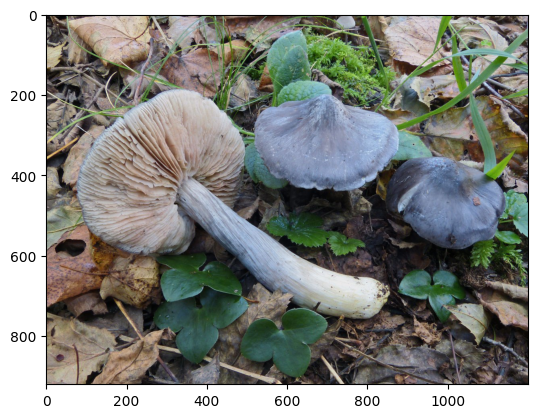

The shape of image is: (1200, 921)


In [4]:
plus = list(data_dir.glob('Entoloma/000*'))
img = Image.open(str(plus[0]))
plt.imshow(img)
plt.show()
print('The shape of image is:', img.size)

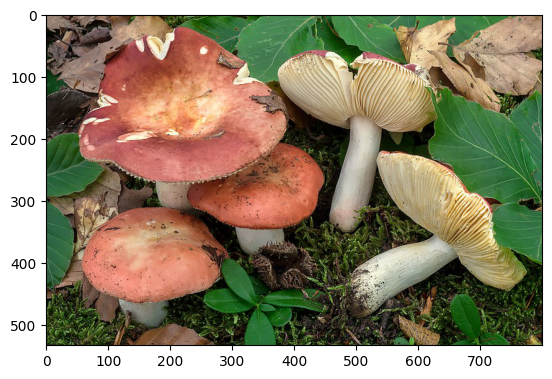

The shape of image is: (800, 533)


In [5]:
plus = list(data_dir.glob('Russula/*'))
img = Image.open(str(plus[15]))
plt.imshow(img)
plt.show()
print('The shape of image is:', img.size)

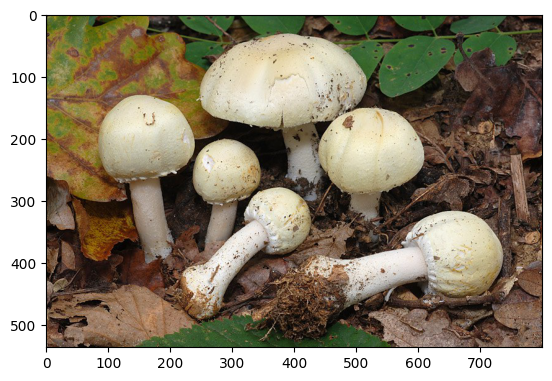

The shape of image is: (800, 536)


In [6]:
plus = list(data_dir.glob('Agaricus/*'))
img = Image.open(str(plus[2]))
plt.imshow(img)
plt.show()
print('The shape of image is:', img.size)

# **Preprocessing**

---



---



In [33]:
#Create train dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset="training",
  seed=123,
  #Here you resize the images, the values you see are an acceptable value for the image, but too
  #high for the computational resources of my computer
  image_size=(700, 500),
  color_mode='grayscale',
  batch_size=50)

Found 6714 files belonging to 9 classes.
Using 5372 files for training.


In [22]:
#Create validation dataset
val_ds = keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #Here you resize the images, the values you see are an acceptable value for the image, but too
  #high for the computational resources of my computer
  image_size=(700, 500),
  color_mode='grayscale',
  batch_size=50)

Found 6714 files belonging to 9 classes.
Using 1342 files for validation.


In [10]:
#print the class names of each class
class_names = val_ds.class_names
num_classes = len(class_names)
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [24]:
#Prepare datasets to process them in parallel
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#Define a normalization layer the rescale the images
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
#Normalize the training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
#Print shapes of images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# **Model creation and evaluation**

---



---



In [25]:
#Define the layers of the Convolutional Neural Network
model = Sequential([
  #Normalization layer
  layers.experimental.preprocessing.Rescaling(1./255),
  #Input layer with the image sizes
  keras.Input(shape=(700, 500, 1)),
  #Convolutional and pooling layers

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  #Dropout and Flatten
  layers.Dropout(0.2),
  layers.Flatten(),

  #Output layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
#Define the CNN parameters
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

From this point, the following cells haven't been executed because the next one, that is the one that trains the model, it's too expensive computationally

In [ ]:
#Train the model 
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In a normal scenario where the model could be trained, the following cell would plot two graphs displaying the loss and accuracy evolution through each epoch. You can see a similar example in the notebook "Handwritten_Digits&Operators_Recognition" where I developed another CNN for a different use case

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

And in these last cells I defined I function to test the CNN by uploading an image and classify it

In [ ]:
def predict_image(img):
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
predict_image(PIL.Image.open(r'/content/1_1_8ccw_10_scaled_x1_3y1.png'))